In [1]:
# 4-12-2022
# Sumani

# https://www.kaggle.com/datasets/rikdifos/credit-card-approval-prediction

# Task - Build a machine learning model to predict if an applicant is 'good' or 'bad' client.

In [2]:
import os, sys

# Import all required modules
import pandas as pd
import numpy as np

# Import plotting modules
import seaborn as sns
sns.set()
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.ticker
%matplotlib inline

# import ML modules
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegression as LR
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.ensemble import RandomForestClassifier as RF
from sklearn.ensemble import GradientBoostingClassifier as GBM
from sklearn.metrics import roc_auc_score as AUC, accuracy_score as accuracy
from sklearn import svm
from sklearn.linear_model import SGDClassifier as SGD
from sklearn.model_selection import train_test_split as tts, cross_val_score as cvs, KFold
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay


In [3]:
# Read the dataset
credit_status_df = pd.read_csv('./input/credit_record.csv')  
application_df = pd.read_csv('./input/application_record.csv') 

## 1. Exploring Credit Status Dataset

In [4]:
credit_status_df.head(10)

,ID,MONTHS_BALANCE,STATUS
0,5001711,0,X
1,5001711,-1,0
2,5001711,-2,0
3,5001711,-3,0
4,5001712,0,C
5,5001712,-1,C
6,5001712,-2,C
7,5001712,-3,C
8,5001712,-4,C
9,5001712,-5,C


In [5]:
# How many rows are there in this dataset?
credit_status_df.shape

(1048575, 3)

<AxesSubplot:xlabel='no_of_months', ylabel='no_of_customers'>

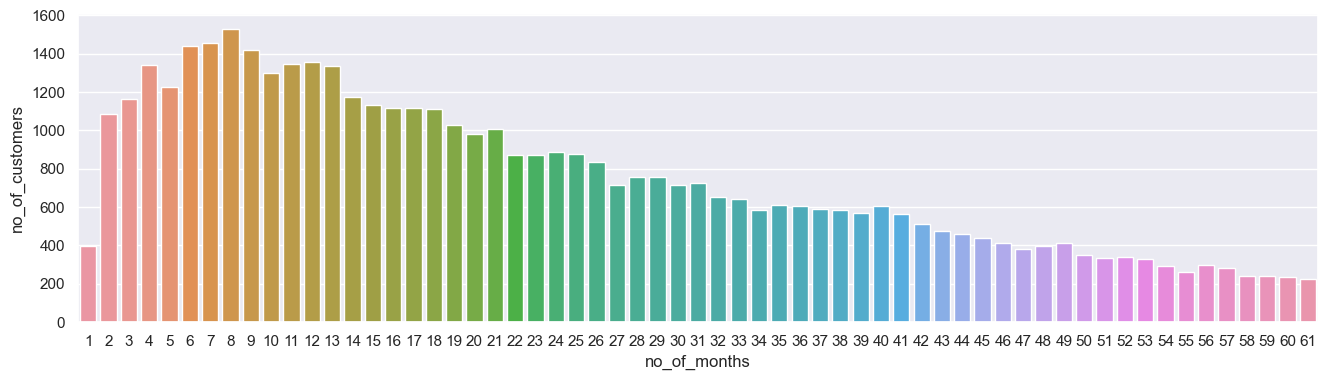

In [6]:
# Let's understand customers vs their months on the book 

df = credit_status_df.groupby('ID').count()
df = df.groupby('STATUS').count()
df = df.reset_index()
df.columns = ['no_of_months', 'no_of_customers']
plt.figure(figsize=(16,4))
sns.barplot(data=df, x="no_of_months", y="no_of_customers") 

In [7]:
credit_status_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1048575 entries, 0 to 1048574
Data columns (total 3 columns):
 #   Column          Non-Null Count    Dtype 
---  ------          --------------    ----- 
 0   ID              1048575 non-null  int64 
 1   MONTHS_BALANCE  1048575 non-null  int64 
 2   STATUS          1048575 non-null  object
dtypes: int64(2), object(1)
memory usage: 24.0+ MB


In [8]:
credit_status_df.describe(include='all').T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
ID,1048575.0,NaN,NaN,NaN,5068286.424673,46150.578505,5001711.0,5023644.0,5062104.0,5113856.0,5150487.0
MONTHS_BALANCE,1048575.0,NaN,NaN,NaN,-19.136998,14.023498,-60.0,-29.0,-17.0,-7.0,0.0
STATUS,1048575,8,C,442031,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [9]:
# Does the dataset has any nulls?
print (credit_status_df.isna().sum())

ID                0
MONTHS_BALANCE    0
STATUS            0
dtype: int64


In [10]:
# What are the unique values for each column?
df = credit_status_df
for c in df.columns:
    n = df[c].nunique()
    print(c)
    if n <= 3:
        print(n, sorted(df[c].value_counts().to_dict().items()))
    else:
        print(n)
    print(10 * '-')

ID
45985
----------
MONTHS_BALANCE
61
----------
STATUS
8
----------


<AxesSubplot:>

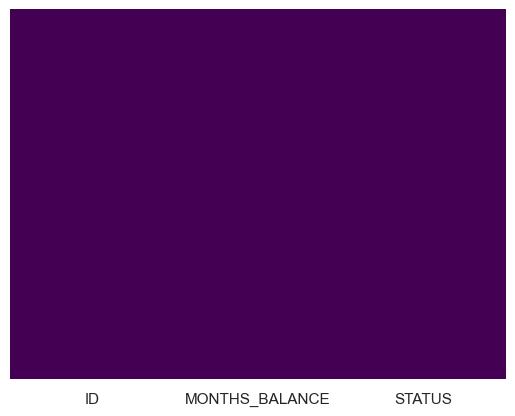

In [11]:
# Check missing values in heatmap 
sns.heatmap(df.isnull(), cbar=False, yticklabels=False, cmap = 'viridis')

# 2. Constructing Labels

C:\Users\SumaniRajadurai\AppData\Local\Temp\ipykernel_25840\225056455.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  credit_status_df['target'][credit_status_df['STATUS'] =='2']= 'Yes'
C:\Users\SumaniRajadurai\AppData\Local\Temp\ipykernel_25840\225056455.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  credit_status_df['target'][credit_status_df['STATUS'] =='3']= 'Yes'
C:\Users\SumaniRajadurai\AppData\Local\Temp\ipykernel_25840\225056455.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/st

0    45318
1      667
Name: target, dtype: int64


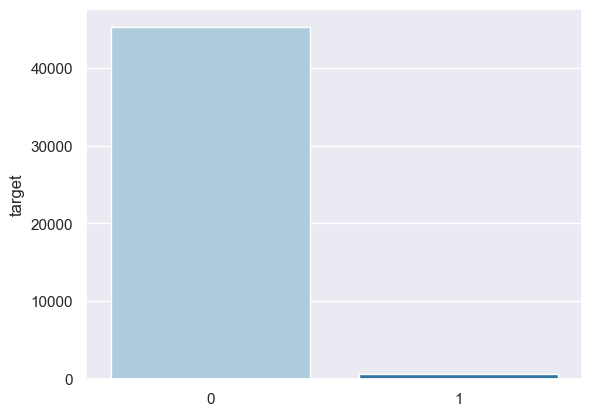

In [12]:
credit_status_df['target'] = None
credit_status_df['target'][credit_status_df['STATUS'] =='2']= 'Yes' 
credit_status_df['target'][credit_status_df['STATUS'] =='3']= 'Yes' 
credit_status_df['target'][credit_status_df['STATUS'] =='4']= 'Yes' 
credit_status_df['target'][credit_status_df['STATUS'] =='5']= 'Yes' 

customer_start_month = pd.DataFrame(credit_status_df.groupby(["ID"])["MONTHS_BALANCE"].agg(min))
customer_start_month=customer_start_month.rename(columns={'MONTHS_BALANCE':'ACCNT_AGE'}) 

miss_payment_count = credit_status_df.groupby('ID').count()
miss_payment_count['target'][miss_payment_count['target'] > 0]='Yes' 
miss_payment_count['target'][miss_payment_count['target'] == 0]='No' 
target_df = miss_payment_count[['target']]
target_df = target_df.reset_index()

target_df.loc[target_df['target']=='Yes','target']=1
target_df.loc[target_df['target']=='No','target']=0

target_df = pd.merge(target_df, customer_start_month, how='inner', on='ID')

print(target_df['target'].value_counts())

ax = sns.barplot(x=target_df['target'].value_counts().index, y=target_df['target'].value_counts(), palette='Paired')
plt.show()
# classes are highly imbalanced.

In [13]:
target_df

,ID,target,ACCNT_AGE
0,5001711,0,-3
1,5001712,0,-18
2,5001713,0,-21
3,5001714,0,-14
4,5001715,0,-59
...,...,...,...
45980,5150482,0,-28
45981,5150483,0,-17
45982,5150484,0,-12
45983,5150485,0,-1


## 3. Exploring application record dataset

In [14]:
application_full_df = pd.merge(application_df,target_df,how='inner',on='ID')

# Sneak peek of the data
application_full_df.head(10)

df = application_full_df

In [15]:
# What is the shape of the data?
print('shape of the data is {}'.format(df.shape))


shape of the data is (36457, 20)


In [16]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 36457 entries, 0 to 36456
Data columns (total 20 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   ID                   36457 non-null  int64  
 1   CODE_GENDER          36457 non-null  object 
 2   FLAG_OWN_CAR         36457 non-null  object 
 3   FLAG_OWN_REALTY      36457 non-null  object 
 4   CNT_CHILDREN         36457 non-null  int64  
 5   AMT_INCOME_TOTAL     36457 non-null  float64
 6   NAME_INCOME_TYPE     36457 non-null  object 
 7   NAME_EDUCATION_TYPE  36457 non-null  object 
 8   NAME_FAMILY_STATUS   36457 non-null  object 
 9   NAME_HOUSING_TYPE    36457 non-null  object 
 10  DAYS_BIRTH           36457 non-null  int64  
 11  DAYS_EMPLOYED        36457 non-null  int64  
 12  FLAG_MOBIL           36457 non-null  int64  
 13  FLAG_WORK_PHONE      36457 non-null  int64  
 14  FLAG_PHONE           36457 non-null  int64  
 15  FLAG_EMAIL           36457 non-null 

In [17]:
# Basic Stats of the df
df.describe().T

,count,mean,std,min,25%,50%,75%,max
ID,36457.0,5.078227e+06,41875.240788,5008804.0,5042028.0,5074614.0,5115396.0,5150487.0
CNT_CHILDREN,36457.0,4.303152e-01,0.742367,0.0,0.0,0.0,1.0,19.0
AMT_INCOME_TOTAL,36457.0,1.866857e+05,101789.226482,27000.0,121500.0,157500.0,225000.0,1575000.0
DAYS_BIRTH,36457.0,-1.597517e+04,4200.549944,-25152.0,-19438.0,-15563.0,-12462.0,-7489.0
DAYS_EMPLOYED,36457.0,5.926294e+04,137651.334859,-15713.0,-3153.0,-1552.0,-408.0,365243.0
FLAG_MOBIL,36457.0,1.000000e+00,0.000000,1.0,1.0,1.0,1.0,1.0
FLAG_WORK_PHONE,36457.0,2.255260e-01,0.417934,0.0,0.0,0.0,0.0,1.0
FLAG_PHONE,36457.0,2.948131e-01,0.455965,0.0,0.0,0.0,1.0,1.0
FLAG_EMAIL,36457.0,8.972214e-02,0.285787,0.0,0.0,0.0,0.0,1.0
CNT_FAM_MEMBERS,36457.0,2.198453e+00,0.911686,1.0,2.0,2.0,3.0,20.0


In [18]:
# Does the dataset has any nulls?
print (df.isna().sum())

ID                         0
CODE_GENDER                0
FLAG_OWN_CAR               0
FLAG_OWN_REALTY            0
CNT_CHILDREN               0
AMT_INCOME_TOTAL           0
NAME_INCOME_TYPE           0
NAME_EDUCATION_TYPE        0
NAME_FAMILY_STATUS         0
NAME_HOUSING_TYPE          0
DAYS_BIRTH                 0
DAYS_EMPLOYED              0
FLAG_MOBIL                 0
FLAG_WORK_PHONE            0
FLAG_PHONE                 0
FLAG_EMAIL                 0
OCCUPATION_TYPE        11323
CNT_FAM_MEMBERS            0
target                     0
ACCNT_AGE                  0
dtype: int64


In [19]:
# What are numerical variables?
for c in df.columns:
    n = df[c].nunique()
    print(c)
    if n <= 3:
        print(n, sorted(df[c].value_counts().to_dict().items()))
    else:
        print(n)
    print(10 * '-')

ID
36457
----------
CODE_GENDER
2 [('F', 24430), ('M', 12027)]
----------
FLAG_OWN_CAR
2 [('N', 22614), ('Y', 13843)]
----------
FLAG_OWN_REALTY
2 [('N', 11951), ('Y', 24506)]
----------
CNT_CHILDREN
9
----------
AMT_INCOME_TOTAL
265
----------
NAME_INCOME_TYPE
5
----------
NAME_EDUCATION_TYPE
5
----------
NAME_FAMILY_STATUS
5
----------
NAME_HOUSING_TYPE
6
----------
DAYS_BIRTH
7183
----------
DAYS_EMPLOYED
3640
----------
FLAG_MOBIL
1 [(1, 36457)]
----------
FLAG_WORK_PHONE
2 [(0, 28235), (1, 8222)]
----------
FLAG_PHONE
2 [(0, 25709), (1, 10748)]
----------
FLAG_EMAIL
2 [(0, 33186), (1, 3271)]
----------
OCCUPATION_TYPE
18
----------
CNT_FAM_MEMBERS
10
----------
target
2 [(0, 35841), (1, 616)]
----------
ACCNT_AGE
61
----------


In [20]:
# What are numerical variables?
numeric_data = df.select_dtypes(include=np.number)
numerical_cols = numeric_data.columns 
print("Numeric Features:")
print (numerical_cols)
numeric_data.head()

# real numerical columns
numerical_cols = ['CNT_CHILDREN', 'AMT_INCOME_TOTAL', 'DAYS_BIRTH', 'DAYS_EMPLOYED', 'CNT_FAM_MEMBERS', 'ACCNT_AGE']

Numeric Features:
Index(['ID', 'CNT_CHILDREN', 'AMT_INCOME_TOTAL', 'DAYS_BIRTH', 'DAYS_EMPLOYED',
       'FLAG_MOBIL', 'FLAG_WORK_PHONE', 'FLAG_PHONE', 'FLAG_EMAIL',
       'CNT_FAM_MEMBERS', 'ACCNT_AGE'],
      dtype='object')


In [21]:
# What are categorical variables?
categorical_data = df.select_dtypes(exclude=np.number)
categorical_cols = categorical_data.columns                                                                              
print("Categorical Features:")
print(categorical_data.head())

# real categorical columns
categorical_cols = ['FLAG_MOBIL', 'FLAG_WORK_PHONE', 'FLAG_PHONE', 'FLAG_EMAIL', 'CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE', 'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE',  'OCCUPATION_TYPE']

# real categorical columns
cat_cols = ['CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE', 'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE',  'OCCUPATION_TYPE']


Categorical Features:
  CODE_GENDER FLAG_OWN_CAR FLAG_OWN_REALTY      NAME_INCOME_TYPE  \
0           M            Y               Y               Working   
1           M            Y               Y               Working   
2           M            Y               Y               Working   
3           F            N               Y  Commercial associate   
4           F            N               Y  Commercial associate   

             NAME_EDUCATION_TYPE    NAME_FAMILY_STATUS  NAME_HOUSING_TYPE  \
0               Higher education        Civil marriage   Rented apartment   
1               Higher education        Civil marriage   Rented apartment   
2  Secondary / secondary special               Married  House / apartment   
3  Secondary / secondary special  Single / not married  House / apartment   
4  Secondary / secondary special  Single / not married  House / apartment   

  OCCUPATION_TYPE target  
0             NaN      0  
1             NaN      0  
2  Security staff      0 

<AxesSubplot:>

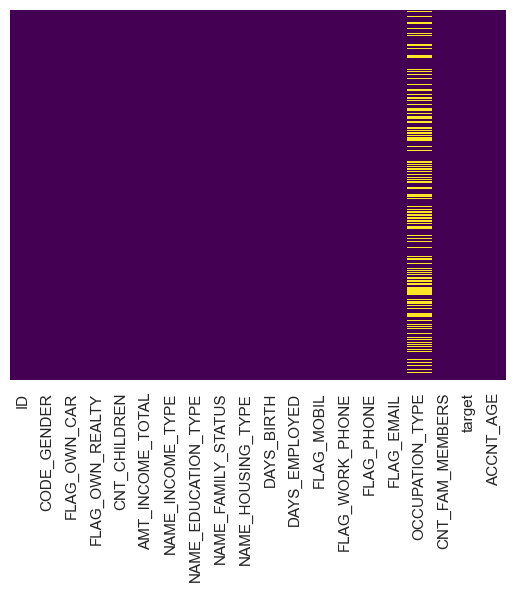

In [22]:
# Check missing values in heatmap
sns.heatmap(df.isnull(), cbar=False, yticklabels=False, cmap = 'viridis')

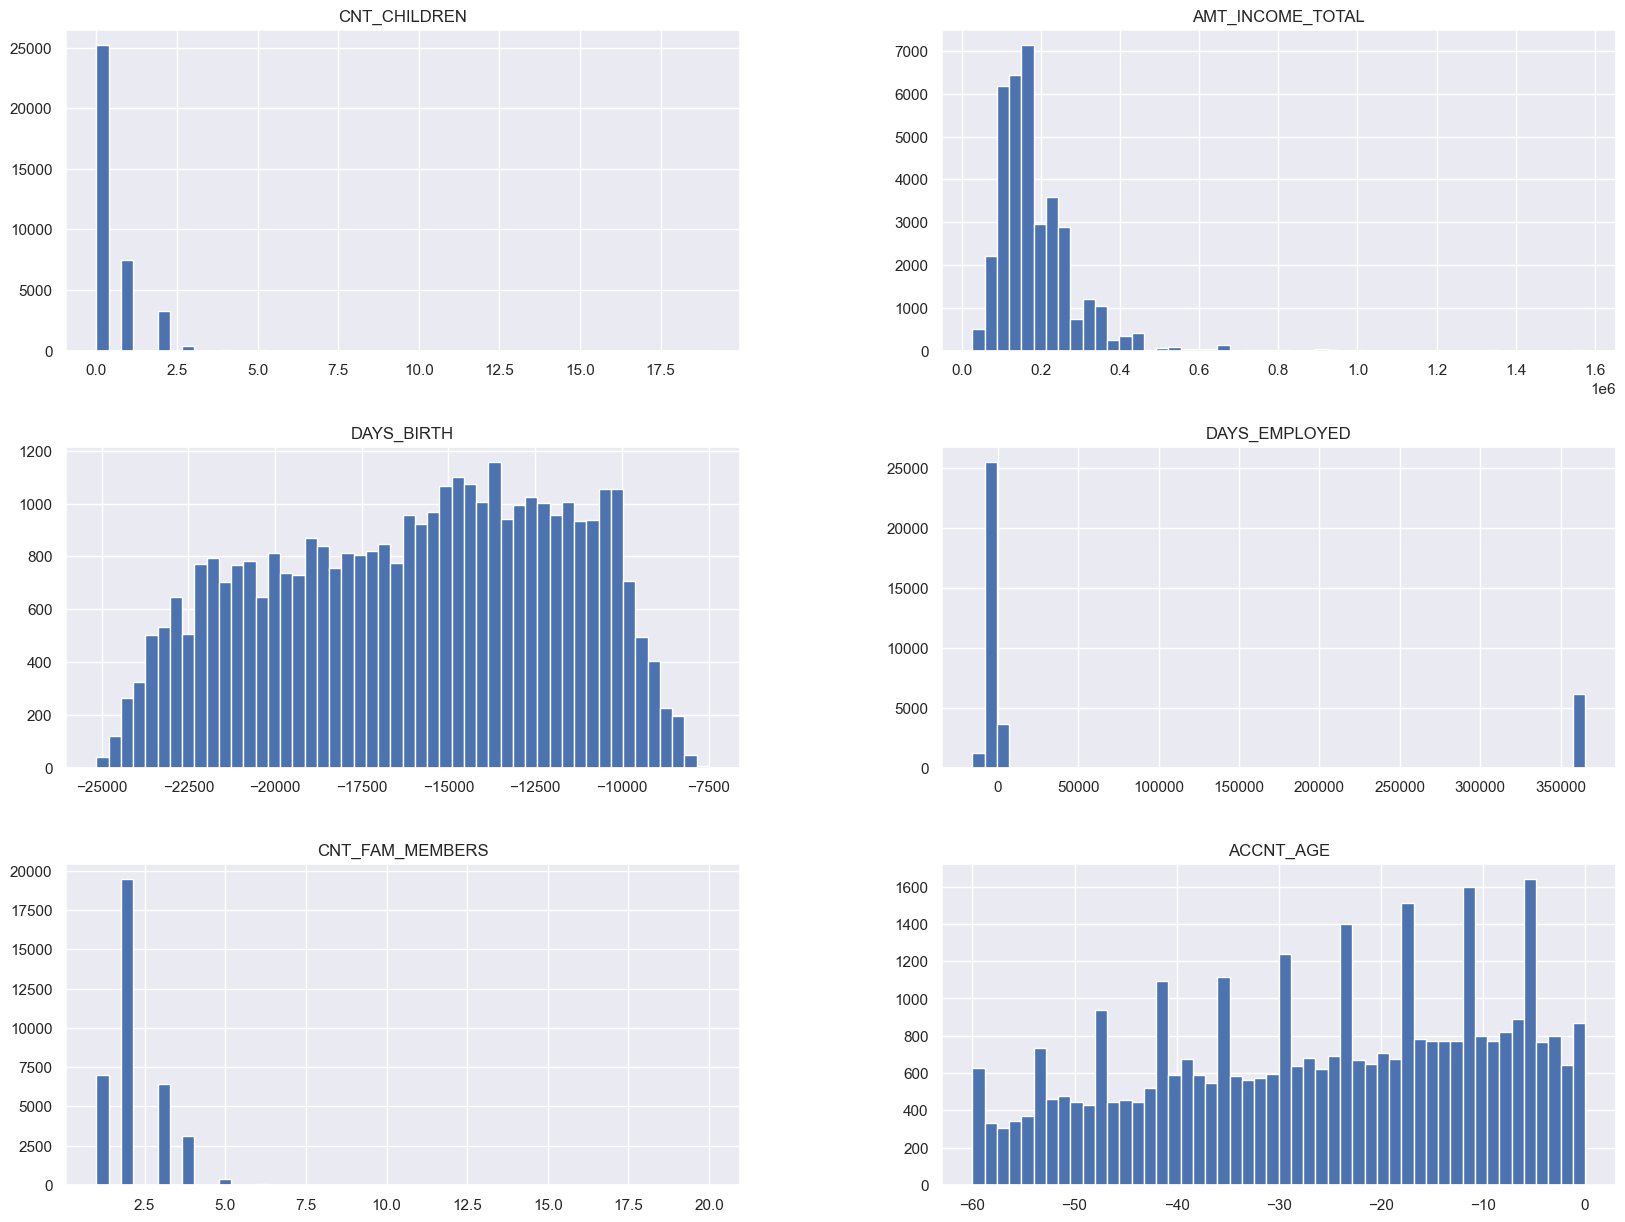

In [23]:
# Understanding Individual Columns

# This plots the distribution of the numerical columns
%matplotlib inline
import matplotlib.pyplot as plt
df[numerical_cols].hist(bins=50, figsize=(20,15))  
plt.show();

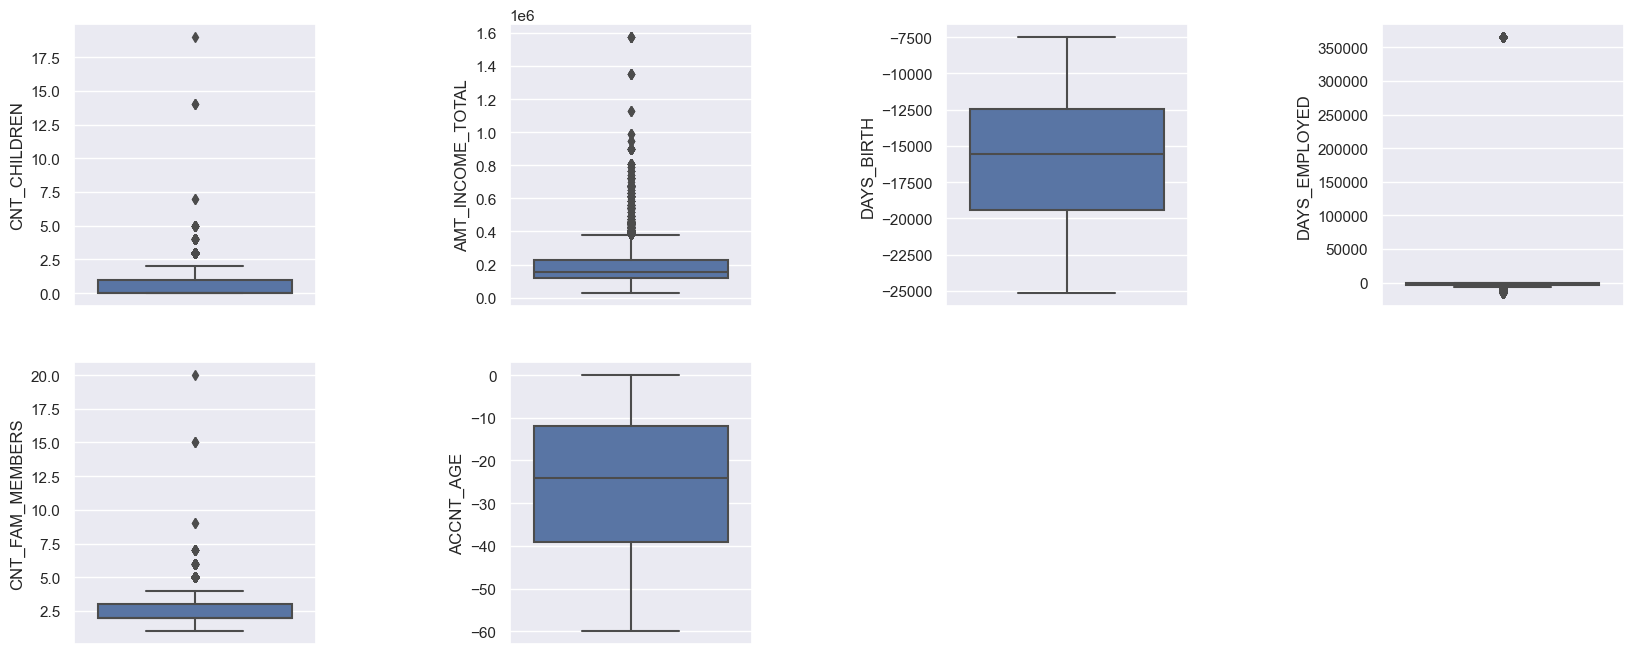

In [24]:
# Detecting outliers also another EDA. Box plot is used to detect outliers withing a single column.

import warnings
warnings.filterwarnings('ignore')
#warnings.filterwarnings(action='once')
import matplotlib.pyplot as plt
import math

l = df[numerical_cols].columns.values
number_of_columns=4
number_of_rows = math.ceil(len(l)-1/number_of_columns)

plt.figure(figsize=(5*number_of_columns,5*number_of_rows))
plt.subplots_adjust(wspace=0.8)

for i in range(0,len(l)):
    plt.subplot(number_of_rows + 1,number_of_columns,i+1);
    sns.boxplot(y=l[i], data=df);

# 3.1 Multi Variate Analysis

##### Understanding relationship between columns


In [25]:
list(df.columns)

['ID',
 'CODE_GENDER',
 'FLAG_OWN_CAR',
 'FLAG_OWN_REALTY',
 'CNT_CHILDREN',
 'AMT_INCOME_TOTAL',
 'NAME_INCOME_TYPE',
 'NAME_EDUCATION_TYPE',
 'NAME_FAMILY_STATUS',
 'NAME_HOUSING_TYPE',
 'DAYS_BIRTH',
 'DAYS_EMPLOYED',
 'FLAG_MOBIL',
 'FLAG_WORK_PHONE',
 'FLAG_PHONE',
 'FLAG_EMAIL',
 'OCCUPATION_TYPE',
 'CNT_FAM_MEMBERS',
 'target',
 'ACCNT_AGE']

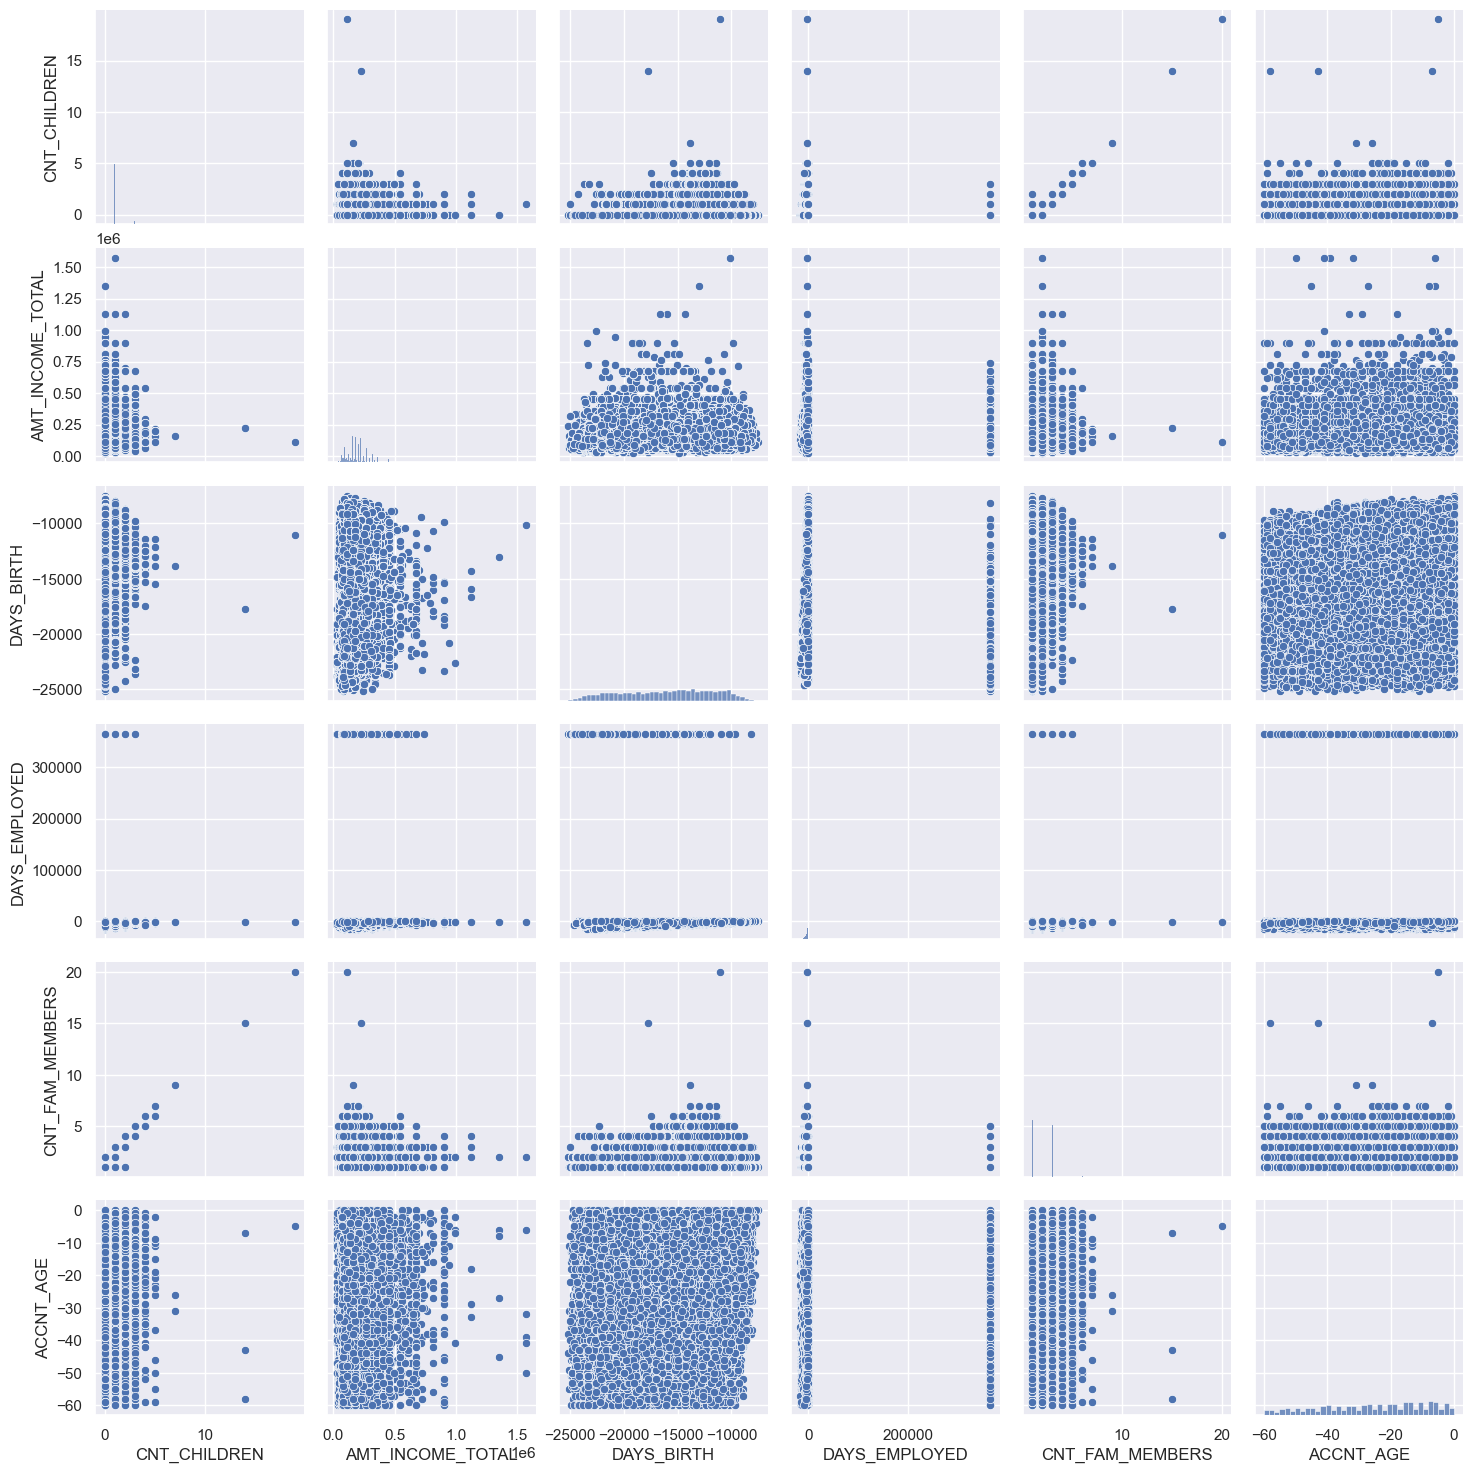

In [26]:
sns.pairplot(df, vars = numerical_cols)

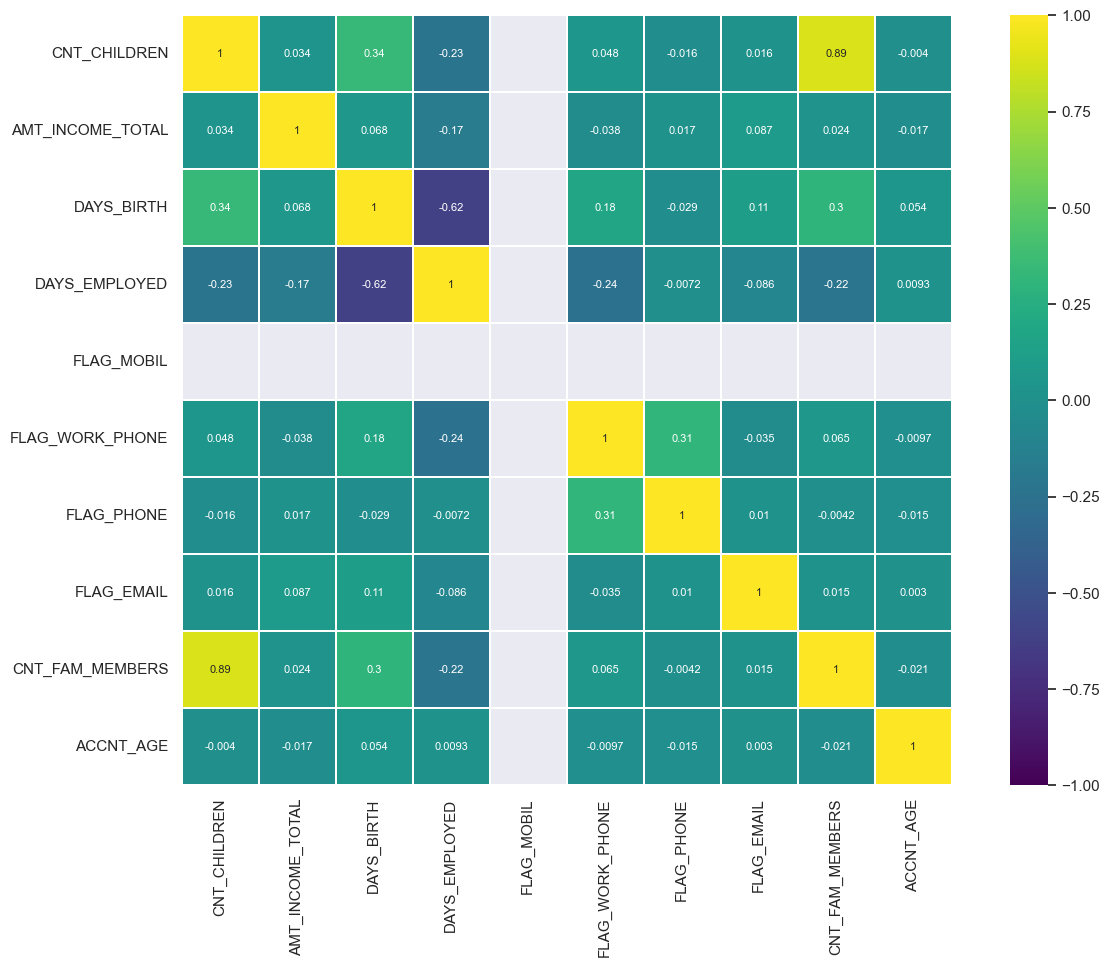

In [27]:
import matplotlib.pyplot as plt
plt.figure(figsize = (15, 10))
# sns.heatmap(df.corr(), annot=True)

df = df.drop(columns='ID')

corr = df.corr()
sns.heatmap(corr, 
            cmap='viridis', vmax=1.0, vmin=-1.0, linewidths=0.3,
            annot=True, annot_kws={"size": 8}, square=True);

In [28]:
application_full_df.describe().T

,count,mean,std,min,25%,50%,75%,max
ID,36457.0,5.078227e+06,41875.240788,5008804.0,5042028.0,5074614.0,5115396.0,5150487.0
CNT_CHILDREN,36457.0,4.303152e-01,0.742367,0.0,0.0,0.0,1.0,19.0
AMT_INCOME_TOTAL,36457.0,1.866857e+05,101789.226482,27000.0,121500.0,157500.0,225000.0,1575000.0
DAYS_BIRTH,36457.0,-1.597517e+04,4200.549944,-25152.0,-19438.0,-15563.0,-12462.0,-7489.0
DAYS_EMPLOYED,36457.0,5.926294e+04,137651.334859,-15713.0,-3153.0,-1552.0,-408.0,365243.0
FLAG_MOBIL,36457.0,1.000000e+00,0.000000,1.0,1.0,1.0,1.0,1.0
FLAG_WORK_PHONE,36457.0,2.255260e-01,0.417934,0.0,0.0,0.0,0.0,1.0
FLAG_PHONE,36457.0,2.948131e-01,0.455965,0.0,0.0,0.0,1.0,1.0
FLAG_EMAIL,36457.0,8.972214e-02,0.285787,0.0,0.0,0.0,0.0,1.0
CNT_FAM_MEMBERS,36457.0,2.198453e+00,0.911686,1.0,2.0,2.0,3.0,20.0


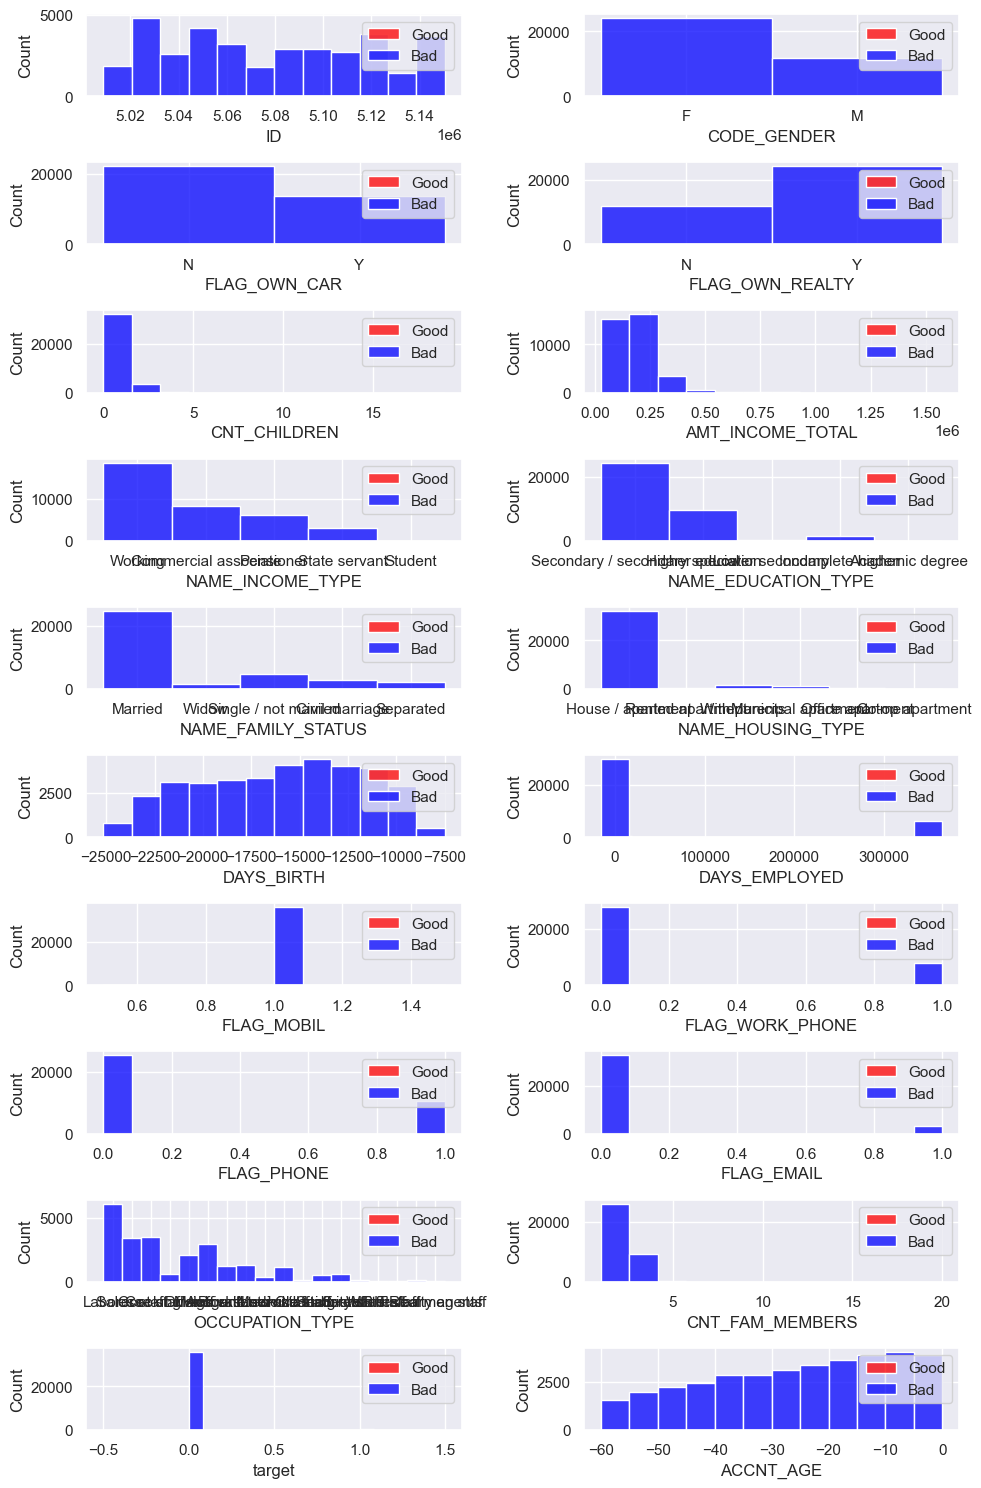

In [29]:
df = application_full_df
import math
bins = 12
plt.figure(figsize=(10,15))
features_mean = list(df.columns)
rows = math.ceil(len(features_mean)/2)
for i, feature in enumerate(features_mean):    
    plt.subplot(rows, 2, i+1)
    
    sns.histplot(df[df['target']== 1][feature], bins=bins, color='red', label='Good');
    sns.histplot(df[df['target']== 0][feature], bins=bins, color='blue', label='Bad');
    
    plt.legend(loc='upper right')

plt.tight_layout()
plt.show()

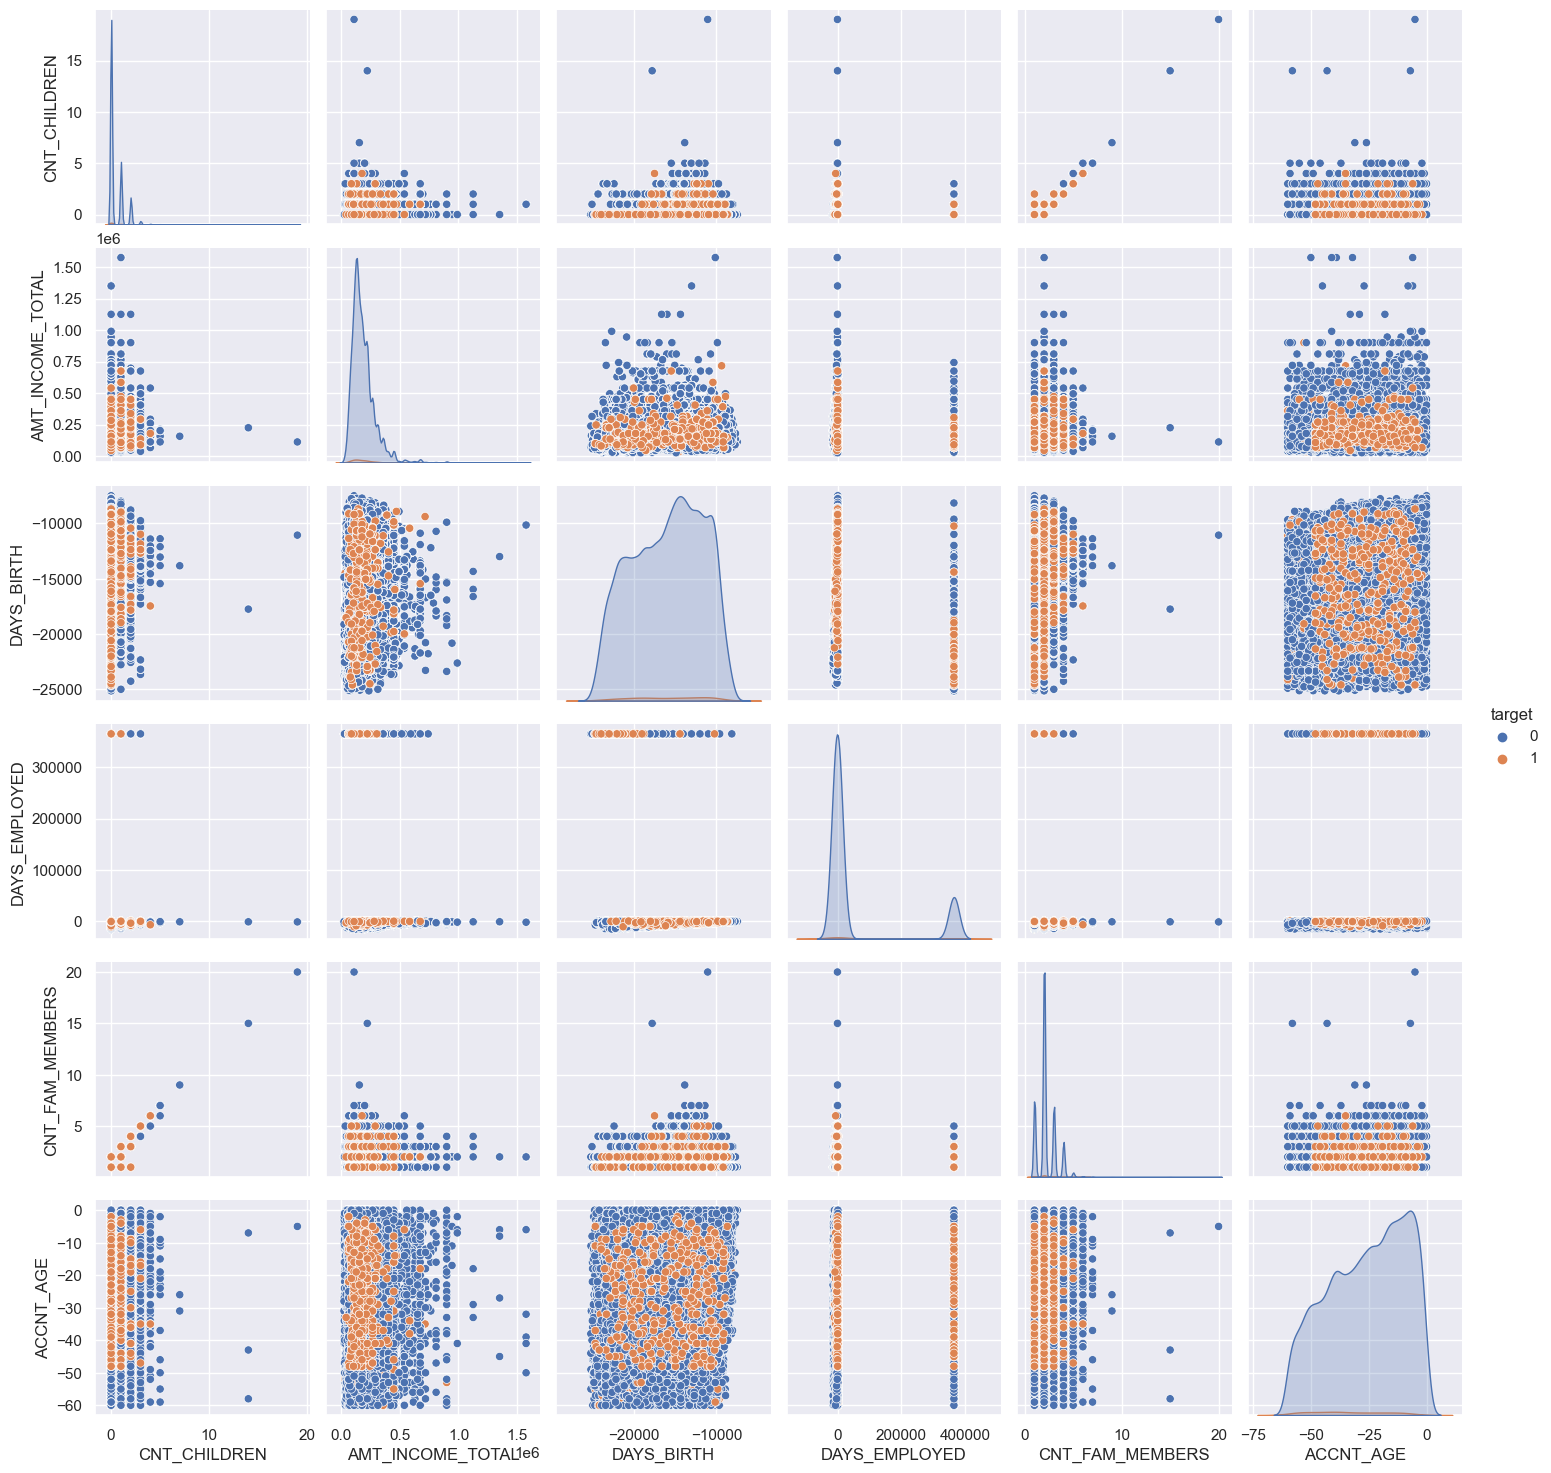

In [30]:
numerical_cols = ['CNT_CHILDREN', 'AMT_INCOME_TOTAL', 'DAYS_BIRTH', 'DAYS_EMPLOYED', 'CNT_FAM_MEMBERS', 'ACCNT_AGE']
sns.pairplot(df, hue = 'target', vars = numerical_cols)

## 3.2 ANOVA

In [31]:
# TODO: Need to do ANOVA Analysis

# 4. Feature engineering

In [32]:
def remove_outliers(data, column):
    '''
        remove outliers 
    '''
    factor = 3
    
    upper_lim = data[column].mean () + data[column].std () * factor
    lower_lim = data[column].mean () - data[column].std () * factor

    data = data[(data[column] < upper_lim) & (data[column] > lower_lim)]
    return data

In [33]:
def one_hot_encoding(data, column):
    #For norminal columns, you have to use onehot encoding
    encoded_columns = pd.get_dummies(data[column])
    
    # rename columns. Append the original column name to the new columns
    new_col_names = []
    for c in encoded_columns.columns:
        new_col_name = column + '_' + c
        new_col_names.append(new_col_name)
    encoded_columns.columns = new_col_names
    
    data = data.join(encoded_columns).drop(column, axis=1)
    return data

In [34]:
application_full_df = pd.merge(application_df,target_df,how='inner',on='ID')

In [35]:
# 1. Handle days and months - convert to absolute value
application_full_df[['DAYS_EMPLOYED','DAYS_BIRTH', 'ACCNT_AGE']] = np.abs(application_full_df[['DAYS_EMPLOYED','DAYS_BIRTH', 'ACCNT_AGE']])

# 2. Remove outliers
application_full_df = remove_outliers(application_full_df, 'CNT_FAM_MEMBERS')
application_full_df = remove_outliers(application_full_df, 'AMT_INCOME_TOTAL')
application_full_df = remove_outliers(application_full_df, 'DAYS_EMPLOYED')

# 3. Drop ID and FLAG_MOBIL columns
if 'ID' in application_full_df.columns:
    application_full_df = application_full_df.drop(columns='ID')
# drop 'FLAG_MOBIL' as all applicants have mobile
if 'FLAG_MOBIL' in application_full_df.columns:
    application_full_df = application_full_df.drop(columns='FLAG_MOBIL')
# drop 'OCCUPATION_TYPE'
if 'OCCUPATION_TYPE' in application_full_df.columns:
    application_full_df = application_full_df.drop(columns='OCCUPATION_TYPE')

# 4. Convert True/False to 'Y' and 'N'
application_full_df['FLAG_WORK_PHONE'] = application_full_df['FLAG_WORK_PHONE'].map({1:'Y',0:'N'})
application_full_df['FLAG_PHONE'] = application_full_df['FLAG_PHONE'].map({1:'Y',0:'N'})
application_full_df['FLAG_EMAIL'] = application_full_df['FLAG_EMAIL'].map({1:'Y',0:'N'})

# 5. Handle skewness
application_full_df['AMT_INCOME_TOTAL'] = np.cbrt(application_full_df['AMT_INCOME_TOTAL'])
application_full_df['DAYS_BIRTH'] = np.cbrt(application_full_df['DAYS_BIRTH'])

# 6. fix retires
application_full_df['DAYS_EMPLOYED'][application_full_df['DAYS_EMPLOYED'] == 365243] = 0

# 7. One Hot Encoding
application_full_df = one_hot_encoding(application_full_df, 'CODE_GENDER')
application_full_df = one_hot_encoding(application_full_df, 'NAME_FAMILY_STATUS')
application_full_df = one_hot_encoding(application_full_df, 'NAME_HOUSING_TYPE')
application_full_df = one_hot_encoding(application_full_df, 'NAME_INCOME_TYPE')
application_full_df = one_hot_encoding(application_full_df, 'FLAG_OWN_CAR')
application_full_df = one_hot_encoding(application_full_df, 'FLAG_OWN_REALTY')
application_full_df = one_hot_encoding(application_full_df, 'FLAG_WORK_PHONE')
application_full_df = one_hot_encoding(application_full_df, 'FLAG_PHONE')
application_full_df = one_hot_encoding(application_full_df, 'FLAG_EMAIL')

# 8. Ordinal Map
EDUCATION_ord_map = {'Lower secondary':0, 
'Secondary / secondary special':1,
'Incomplete higher':2,
'Higher education':3,
'Academic degree':4}

application_full_df['NAME_EDUCATION_TYPE'+ '_LABEL'] = application_full_df['NAME_EDUCATION_TYPE'].map(EDUCATION_ord_map)
application_full_df = application_full_df.drop(columns='NAME_EDUCATION_TYPE')

# 9. minmax scaling
min_max_enc = MinMaxScaler()
application_full_df['DAYS_BIRTH_NORM'] = min_max_enc.fit_transform(application_full_df[['DAYS_BIRTH']])
application_full_df['AMT_INCOME_TOTAL_NORM'] = min_max_enc.fit_transform(application_full_df[['AMT_INCOME_TOTAL']])
application_full_df['ACCNT_AGE_NORM'] = min_max_enc.fit_transform(application_full_df[['ACCNT_AGE']])
application_full_df['DAYS_EMPLOYED_NORM'] = min_max_enc.fit_transform(application_full_df[['DAYS_EMPLOYED']])

# 10. fix the imbalance data
from imblearn.over_sampling import SMOTE
smote = SMOTE()
X, y = smote.fit_resample(application_full_df.loc[:, application_full_df.columns != 'target'],application_full_df['target'].astype('int64'))
application_full_df = pd.concat([pd.DataFrame(X),pd.DataFrame(y)],axis=1)


In [ ]:
application_full_df.info()

# 5. Model Training

In [50]:
classifiers = {
    'LR_10': LR( C = 10 ),
    'LR_1': LR( C = 1 ),
    'LR_01': LR( C = 0.1 ),

#     make_pipeline( StandardScaler(), LR()),
    'Pipe_SS_LR_10': make_pipeline( StandardScaler(), LR( C = 10 )),
#     make_pipeline( StandardScaler(), LR( C = 30 )),

    'Pipe_MS_LR': make_pipeline( MinMaxScaler(), LR()),
#     make_pipeline( MinMaxScaler(), LR( C = 10 )),
    'Pipe_MS_LR_30': make_pipeline( MinMaxScaler(), LR( C = 30 )),

    'LDA': LDA(),
    'RF_100_1': RF( n_estimators = 10, min_samples_leaf = 1 ),
    'RF_100_2': RF( n_estimators = 10, min_samples_leaf = 2 ),
#     RF( n_estimators = 100, min_samples_leaf = 5 ),
#     RF( n_estimators = 100, min_samples_leaf = 10 ),
#     RF( n_estimators = 100, min_samples_leaf = 15 ),
#     RF( n_estimators = 100, min_samples_leaf = 25 ),
#     RF( n_estimators = 1000, min_samples_leaf = 50 ),
#     make_pipeline( StandardScaler(), RF( n_estimators = 1000, min_samples_leaf = 50 )),
    'GBM_1': GBM(learning_rate=0.1, n_estimators=10, min_samples_leaf=100, max_depth=10, tol=0.001),
    # GBM(learning_rate=0.01, n_estimators=100, min_samples_leaf=100, max_depth=10, tol=0.0001),
#     GBM(learning_rate=0.05, n_estimators=100, min_samples_leaf=100, max_depth=10, tol=0.0001),
#     GBM(learning_rate=0.05, n_estimators=50, min_samples_leaf=50, max_depth=10, tol=0.0001),
    'SVC': svm.SVC(gamma='scale', probability=True),
#     svm.SVC(gamma='auto', probability=True),
    'SGD': SGD(loss='modified_huber')
}

In [51]:
def plot_alg_comparision(acc, names):
    fig = plt.figure()
    fig.suptitle('Algorithm Comparison')
    ax = fig.add_subplot(111)
    plt.boxplot(acc)
    ax.set_xticklabels(names, rotation=45)
    plt.show()

def print_accuracy(acc, names):
    # print the accuracy numbers in one shot
    data = {'accuracy':acc}
    df = pd.DataFrame(data, index=names)
    df['accuracy'] = df['accuracy'].map(lambda x: np.round(x, 2))
    df['mean_acc'] = df['accuracy'].map(np.mean)
    return df

In [38]:
acc = []   # list for collecting Accuracy of all model
names = []    # List of model name

def train_and_cvs(features):
    '''This function trains list of models and plots those model's accuracy'''
    for name, clf in classifiers.items():
        scores = cvs(clf, features.drop( 'target', axis = 1 ), features.target, cv=10)
        
        acc.append(scores)
        names.append(name)
        print('{} - {} - {}'.format(name, clf, np.round (np.mean(scores), 2)))
    plot_alg_comparision(acc, names)

LR_10 - LogisticRegression(C=10) - 0.85
LR_1 - LogisticRegression(C=1) - 0.85
LR_01 - LogisticRegression(C=0.1) - 0.86
Pipe_SS_LR_10 - Pipeline(steps=[('standardscaler', StandardScaler()),
                ('logisticregression', LogisticRegression(C=10))]) - 0.96
Pipe_MS_LR - Pipeline(steps=[('minmaxscaler', MinMaxScaler()),
                ('logisticregression', LogisticRegression())]) - 0.91
Pipe_MS_LR_30 - Pipeline(steps=[('minmaxscaler', MinMaxScaler()),
                ('logisticregression', LogisticRegression(C=30))]) - 0.92
LDA - LinearDiscriminantAnalysis() - 0.93
RF_100_1 - RandomForestClassifier(n_estimators=10) - 0.99
RF_100_2 - RandomForestClassifier(min_samples_leaf=2, n_estimators=10) - 0.99


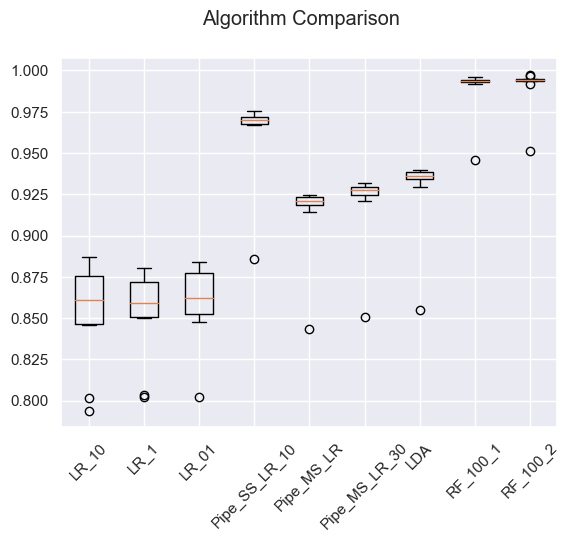

In [39]:
train_and_cvs(application_full_df)

In [49]:
acc_df = print_accuracy(acc, names)
with pd.option_context("display.max_colwidth", None):
    display(acc_df)

,accuracy,mean_acc
LR_10,"[0.8, 0.89, 0.86, 0.79, 0.88, 0.88, 0.85, 0.86, 0.85, 0.87]",0.853
LR_1,"[0.8, 0.87, 0.86, 0.8, 0.88, 0.88, 0.85, 0.86, 0.85, 0.86]",0.851
LR_01,"[0.8, 0.88, 0.86, 0.86, 0.88, 0.88, 0.85, 0.88, 0.85, 0.87]",0.861
Pipe_SS_LR_10,"[0.89, 0.97, 0.97, 0.97, 0.97, 0.98, 0.97, 0.97, 0.97, 0.97]",0.963
Pipe_MS_LR,"[0.84, 0.92, 0.91, 0.92, 0.92, 0.92, 0.92, 0.92, 0.92, 0.92]",0.911
Pipe_MS_LR_30,"[0.85, 0.93, 0.92, 0.93, 0.93, 0.93, 0.92, 0.93, 0.93, 0.93]",0.920
LDA,"[0.85, 0.94, 0.93, 0.94, 0.93, 0.94, 0.94, 0.94, 0.93, 0.94]",0.928
RF_100_1,"[0.95, 0.99, 0.99, 0.99, 0.99, 1.0, 0.99, 0.99, 0.99, 0.99]",0.987
RF_100_2,"[0.95, 0.99, 1.0, 0.99, 1.0, 1.0, 0.99, 0.99, 0.99, 0.99]",0.989


In [52]:
def gini(list_of_values):
    sorted_list = sorted(list_of_values)
    height, area = 0, 0
    for value in sorted_list:
        height += value
        area += height - value / 2.
    fair_area = height * len(list_of_values) / 2.
    return (fair_area - area) / fair_area

def normalized_gini(y_pred, y):
    normalized_gini = gini(y_pred)/gini(y)
    return normalized_gini

In [53]:
def train_and_evaluate(dataset, clf):
    '''This function trains a single model'''
    x_train, x_test, y_train, y_test = tts(dataset.drop( 'target', axis = 1 ), dataset.target)
    
    clf.fit( x_train, y_train )
    p = clf.predict_proba( x_test )[:,1]
    p_bin = clf.predict( x_test )

    #evaluation matrices

    #accuracy
    acc = accuracy( y_test, p_bin )
    print ('accuracy - {}\n'.format(acc))

    #confusion matrix
    cm = confusion_matrix(y_test, p_bin)
    print ('confusion matrix \n {}\n'.format(cm))

    #auc-roc
    auc = AUC( y_test, p )
    print ('auc - {}\n'.format(auc))

    #gini
    gini_score = gini(p)
    print ('gini_score - {}\n'.format(gini_score))
    
#     disp = ConfusionMatrixDisplay(confusion_matrix=cm,
#                                display_labels=clf.classes_)
#     disp.plot()
#     plt.show()

    ConfusionMatrixDisplay
    disp = ConfusionMatrixDisplay.from_predictions(y_test, p_bin)
    disp.figure_.suptitle("Confusion Matrix")
    print(f"Confusion matrix:\n{disp.confusion_matrix}")
    plt.show()    

accuracy - 0.9930607329242416

confusion matrix 
 [[8674   28]
 [  93 8642]]

auc - 0.9980845582610213

gini_score - 0.49240530433391944

Confusion matrix:
[[8674   28]
 [  93 8642]]


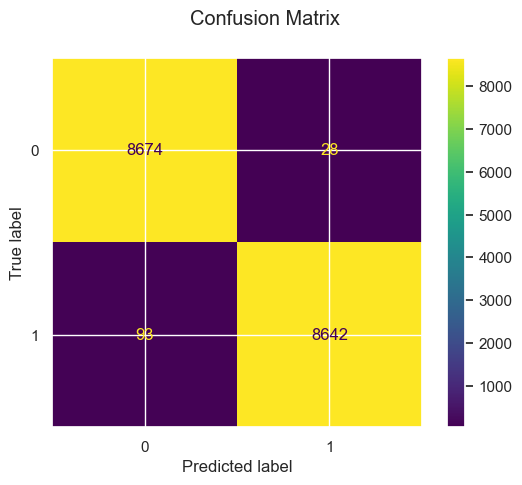

In [54]:
train_and_evaluate(application_full_df, LR( C = 0.1 ))